# CLIP

CLIP (Contrastive Language–Image Pre-training) — это модель, разработанная компанией OpenAI, которая обучается понимать и соотносить изображения и текст.

CLIP учится определять сходство между представлениями изображений и текстовыми представлениями, что позволяет ей выполнять различные задачи, такие как распознавание содержимого изображений, поиск по изображениям с использованием текстовых запросов и наоборот.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L12/clip_idea.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2103.00020">Learning Transferable Visual Models From Natural Language Supervision</a></em></center>

Для обучения модели был создан новый датасет, включающий 400M пар изображение–текст.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L12/clip_classifier.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2103.00020">Learning Transferable Visual Models From Natural Language Supervision</a></em></center>

Для использования в качестве классификатора достаточно создать текстовый эмбеддинг для слова, описывающего каждый класс, а затем сравнить его с эмбеддингом изображения.

<center><img src ="https://ml.gan4x4.ru/msu/dep-2.1/L12/clip_performance.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2103.00020">Learning Transferable Visual Models From Natural Language Supervision</a></em></center>

Точность классификации не дотягивает до SOTA supervised моделей, но зато работает без дообучения на различных датасетах.

## Как использовать

Установка:

In [1]:
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 494.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00


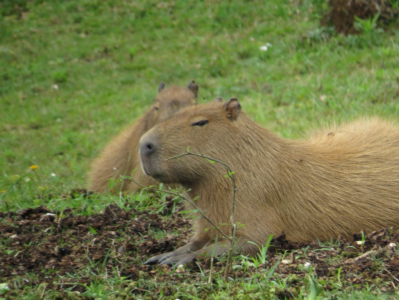

In [4]:
from PIL import Image
import torchvision
from torchvision.transforms import v2

URL = (
    "https://ml.gan4x4.ru/msu/dep-2.1/L12/capybara_image.jpg"
)

!wget -q $URL -O test.jpg
input_img = Image.open("/content/test.jpg")
input_img = v2.Resize(size=300)(input_img)
display(input_img)

На вход CLIP надо подать список текстов, на выходе получим оценку того, какой из них больше всего подходит к изображению.

In [5]:
texts = [
    "capybara on grass",
    "two capybaras on grass",
    "capybara",
    "dog",
]

Можно использовать разные backbone:

In [6]:
import clip

print(clip.available_models())

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


Создаем экземпляр модели:

In [7]:
model, preprocess = clip.load("ViT-B/32", device="cpu")

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.2MiB/s]


Дополнительно получили объект `preprocess` с необходимыми трансформациями. Подготовим с их помощью изображение и токенизируем текст:



In [8]:
image = preprocess(input_img).unsqueeze(0)
text = clip.tokenize(texts)

Теперь можно запускать:

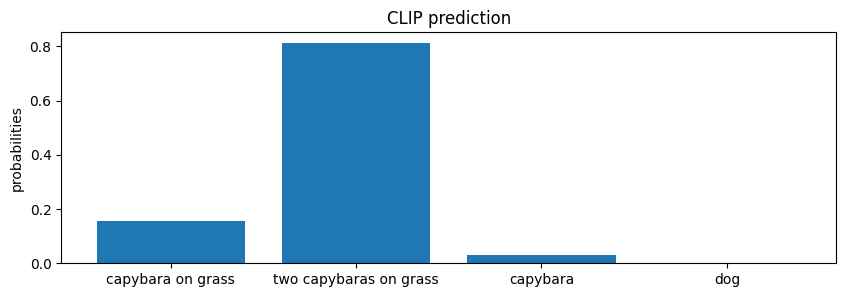

In [11]:
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    logits_per_image, _ = model(image, text)
    probs = logits_per_image.softmax(dim=-1).numpy()

plt.figure(figsize=(10, 3))
plt.bar(range(len(texts)), probs.flatten())
plt.xticks(range(len(texts)), texts)
plt.ylabel("probabilities")
plt.title("CLIP prediction")
plt.show()

## Получение embedding

Вот так можно извлечь признаки для картинки и для текста:

In [12]:
image_features = model.encode_image(image).detach().cpu()
text_features = model.encode_text(text).detach().cpu()
print("Image", image_features.shape)
print("Text", text_features.shape)

Image torch.Size([1, 512])
Text torch.Size([4, 512])


Чтобы сравнить вектора признаков изображений и текстов, нам нужна какая-то метрика расстояния между ними. Удобно использовать [косинусное расстояние 📚[wiki]](https://en.wikipedia.org/wiki/Cosine_similarity):



Эмбеддинги на выходе CLIP не нормализованы:

In [14]:
import numpy as np

print(np.linalg.norm(image_features[0]))

10.614218


Нормализуем их:

In [15]:
from torch.nn.functional import normalize

image_features = normalize(image_features)
text_features = normalize(text_features)

print(np.linalg.norm(image_features[0].cpu()))
print(np.linalg.norm(text_features.cpu(), axis=1))

1.0
[1.        1.        0.9999999 1.0000001]


Теперь мы можем посчитать скалярное произведение вектора признаков для каждого текста с картинкой и понять, насколько они похожи:

In [16]:
similarities = []
for t in text_features:
    sim = torch.dot(image_features[0], t)
    similarities.append(round(sim.item(), 3))
print("similarities:", similarities)

similarities: [0.374, 0.391, 0.358, 0.21]


Разрыв уже не такой внушительный, как после softmax:

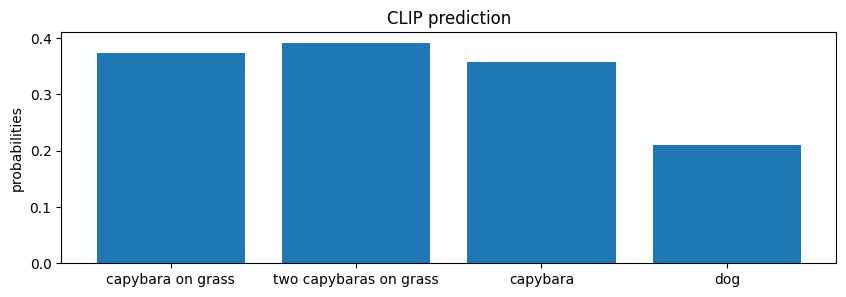

In [17]:
plt.figure(figsize=(10, 3))
plt.bar(range(len(similarities)), similarities)
plt.xticks(range(len(texts)), texts)
plt.ylabel("probabilities")
plt.title("CLIP prediction")
plt.show()

Но можно умножить расстояния на константу перед отправкой в softmax:

In [18]:
sims = torch.tensor(similarities)
chilled_sims = sims.flatten() * 100

И тогда результат совпадет с тем, что выдал CLIP:

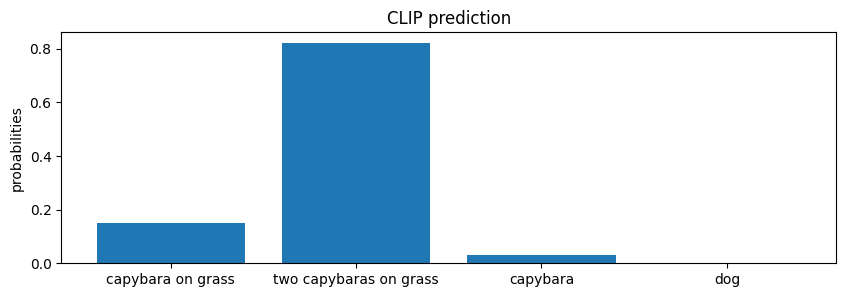

In [19]:
s = chilled_sims.softmax(dim=0).numpy()

plt.figure(figsize=(10, 3))
plt.bar(range(len(s)), s)
plt.xticks(range(len(texts)), texts)
plt.ylabel("probabilities")
plt.title("CLIP prediction")
plt.show()

[[colab] 🥨 Обучение без использования разметки BYOL](https://colab.research.google.com/github/Gan4x4/cv/blob/main/Representation_learning/BYOL.ipynb)